#Style Transfer
by Tejaishwarya Gagadham (tg1779), Shreyas M Kumar (sm7887), Likith Purushotham (lp2267) 

## Introduction:

*Style Transfer* is the method of recomposing a target/content image in the style of another image. This is based on *Gatys et al*'s unprecedented [paper](https://arxiv.org/abs/1508.06576) on the inner-workings of transfering an artistic style from one painting to another picture using convolutional neural networks.

Transferring the style from source image onto the content image can be categorized as a texture transfer too. In texture transfer the idea is to extract textures from a source image
while restricting the texture synthesis, in order to preserve
the semantic content of a target image. 

## Explanation:


Two images are input to the neural network: A content-image and a style-image. 

We want to generate a mixed-image which has the contours of the content-image and the colours and texture of the style-image.

We create several loss-functions that need to be optimized.

The *loss-function for the content-image* tries to minimize the difference between the features that are activated for the content-image and for the mixed-image, at one or more layers in the network. This causes the contours of the mixed-image to resemble those of the content-image.

The *loss-function for the style-image* is slightly more complex, because it tries to minimize the difference between the so-called Gram-matrices for the style-image and the mixed-image. This is done at one or more layers in the network. The Gram-matrix measures which features are activated simultaneously in a given layer. Changing the mixed-image so that it mimics the activation patterns of the style-image causes the colour and texture to be transferred.

Using the TensorFlow to automatically derive the gradient for these loss-functions. The gradient is then used to update the mixed-image. This procedure is repeated a number of times until we are satisfied with the resulting image.


Importing the necessary libraries, including PIL (Python Imaging Library) which adds image processing capabilities, and Tensorflow for processing neural networks.

In [0]:
import os
os.mkdir('images')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image 
from PIL import ImageEnhance

In [0]:
import tensorflow.keras.backend as k
from tensorflow.keras import applications
from tensorflow.keras.applications import vgg16

In [0]:
k.clear_session()

We are using VGG-16, a pre-trained convolutional neural network model. 

In [4]:
!wget https://raw.githubusercontent.com/llSourcell/How_to_do_style_transfer_in_tensorflow/master/vgg16.py

--2019-05-19 23:27:27--  https://raw.githubusercontent.com/llSourcell/How_to_do_style_transfer_in_tensorflow/master/vgg16.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6321 (6.2K) [text/plain]
Saving to: ‘vgg16.py’

vgg16.py            100%[===================>]   6.17K  --.-KB/s    in 0s      

2019-05-19 23:27:27 (129 MB/s) - ‘vgg16.py’ saved [6321/6321]



In [5]:
!wget https://raw.githubusercontent.com/llSourcell/How_to_do_style_transfer_in_tensorflow/master/download.py

--2019-05-19 23:27:27--  https://raw.githubusercontent.com/llSourcell/How_to_do_style_transfer_in_tensorflow/master/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3161 (3.1K) [text/plain]
Saving to: ‘download.py’

download.py         100%[===================>]   3.09K  --.-KB/s    in 0s      

2019-05-19 23:27:28 (105 MB/s) - ‘download.py’ saved [3161/3161]



In [0]:
import vgg16

Download the data for the VGG-16 model if it doesn't already exist in the directory.

**WARNING: It is 550 MB!**

In [18]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


##Preparing the images for the transfer:



This function loads an image and returns it as a numpy array of floating-points. The image can be automatically resized so the largest of the height or width equals `max_size`.

In [0]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculates the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scales the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resizes the image using the Lanczos filter.
        image = image.resize(size, PIL.Image.LANCZOS)  
 
    # Converts to numpy floating-point array.
    return np.float32(image)

This function plots the final (mixed) image, in a larger dimension. The image is given as a numpy array with pixel-values between 0 and 255.

In [0]:
#for the final combined image:
def plot_mixed_image(image):
    # Ensures that the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

This function plots the content-, mixed- and style-images.

In [0]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
        #Provides the best possible recontruction of the image.
    else:
        interpolation = 'nearest' 
        #Upsampling the image to take the nearest neighbor's values. 

    # Plotting the content-image.
    # The pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image.
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Loss Functions


This function calculates the Mean Squared Error between the two input tensors. We compare the following loss functions, and the respective outputs to find the most optimal result.

In [0]:
def mean_squared_error(a, b):
  return tf.losses.mean_squared_error(a,b)
  #return tf.losses.huber_loss(a,b)
  #return tf.log(tf.cosh(a-b))  
  #return tf.losses.logcosh(a, b)
  #return tf.reduce_mean(tf.square(a - b))

This function creates the loss-function for the content-image. It is the Mean Squared Error of the feature activations in the given layers in the model, between the content-image and the mixed-image. 

When this content loss function is minimized, it means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers are selected, it should transfer the respective contours from the content-image to the mixed-image.

In [0]:
def create_content_loss(session, model, content_image, layer_ids):
    
    
    #session: An open tensorflow session for running the model's graph.
    #model: The VGG16 model.
    #content_image: Numpy float array with the content-image.
    #layer_ids: List of integer id's for the layers to use in the model.
    
    
    # Creates a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Gets references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculates the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default to add more
    # computational nodes to it. 
    with model.graph.as_default():
      
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
          
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. 
            
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            
            loss = mean_squared_error(layer, value_const)

            layer_losses.append(loss)

        # The combined loss for all layers is the average.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

For the style-layers, but find out which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

This is achiveved by calculating the [Gram-matrix](https://en.wikipedia.org/wiki/Gramian_matrix) for the tensor outputs by the convolutional style-layers in the neural network. The Gram-matrix is the matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.


In [0]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Gets the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshapes the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculates the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram                            

Similar to the above content loss, the following function measures the Mean Squared Error for the Gram-matrices (instead of the raw tensor-outputs from the layers, like in the case of content loss). 

In [0]:
def create_style_loss(session, model, style_image, layer_ids):
  
    #session: An open tensorflow session for running the model's graph.
    #model: The VGG16 model.
    #content_image: Numpy float array with the content-image.
    #layer_ids: List of integer id's for the layers to use in the model.

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. 
    with model.graph.as_default():
      
        # Constructs the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculates the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
          
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image.
            
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
           
            loss = mean_squared_error(gram_layer, value_const)

            layer_losses.append(loss)

        # The combined loss for all layers is  the average.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called [Total Variation Denoising](https://en.wikipedia.org/wiki/Total_variation_denoising) and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [0]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Style-Transfer Algorithm

This is the main optimization algorithm for the Style-Transfer algorithm. This is the gradient descent on the loss-functions calculated above. Using gradient descent we find an image that minimizes the loss-functions of the content-layers and style-layers. This should result in a mixed-image that resembles the contours of the content-image, and resembles the colours and textures of the style-image.

This algorithm also uses normalization of the loss-functions. In each iteration of the optimization, the loss-values are adjusted so each of them equals one - which allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

In [0]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=0.5, weight_style=10000,
                   weight_denoise=0.10,
                   num_iterations=300, step_size=1.0):
   
    
   
    #content_image: Numpy 3-dim float-array with the content-image.
    #style_image: Numpy 3-dim float-array with the style-image.
    #content_layer_ids: List of integers identifying the content-layers.
    #style_layer_ids: List of integers identifying the style-layers.
    #weight_content: Weight for the content-loss-function.
    #weight_style: Weight for the style-loss-function.
    #weight_denoise: Weight for the denoising-loss-function.
    #num_iterations: Number of optimization iterations to perform.
    #step_size: Step-size for the gradient in each iteration.
  
    model = vgg16.VGG16()

    # Creates a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Prints the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Prints the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Creates the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Creates the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Creates the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Creates TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initializes the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that is minimizes
    # below in order to generate the mixed-image.
    
    
    # Multiplying the loss-values, their reciprocal adjustment values and 
    # their relative weights.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Using TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that needed to run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Creates a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Using TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduces the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scales the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Updates the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensures the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_mixed_image(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    return mixed_image

## Final Execution:

Loads the content-image which has the overall contours that we want in the mixed-image.

In [0]:
content_filename = 'images/yann_lecun.jpeg'
content_image = load_image(content_filename, max_size=None)

Loads the style-image which has the colours and textures we want in the mixed-image.

In [0]:
style_filename = 'images/style7.jpg'
style_image = load_image(style_filename, max_size=300)

Then we define a list of integers which identify the layers in the neural network that we want to use for matching the content-image. These are indices into the layers in the neural network. For the VGG16 model, the 5th layer (index 4) seems to work well as the sole content-layer.

In [0]:
content_layer_ids = [4]

Then we define another list of integers for the style-layers.

In [0]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

The following performs the final style transfer. It creates the appropriate loss-functions for the style- and content-layers, and then performs a number of optimization iterations. This will gradually create a mixed-image which has similar contours as the content-image, with the colours and textures being similar to the style-image.

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.29e-11, Style: 6.73e-30, Denoise: 9.40e-07


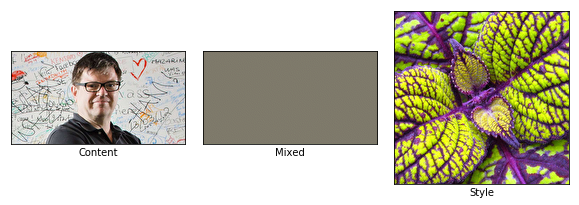

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 6.10e-11, Style: 1.01e-28, Denoise: 5.25e-08


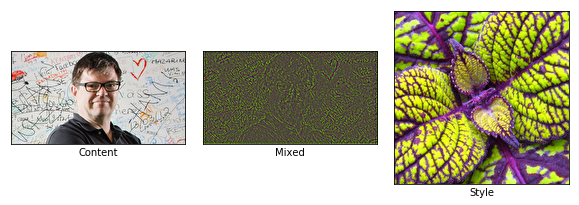

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 5.99e-11, Style: 4.08e-28, Denoise: 4.56e-08


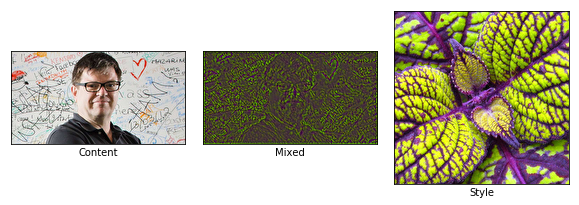

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 6.11e-11, Style: 3.15e-28, Denoise: 4.93e-08


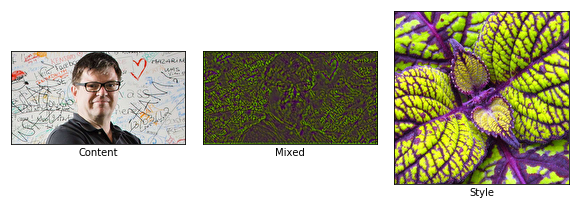

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 5.14e-11, Style: 1.05e-28, Denoise: 3.41e-08


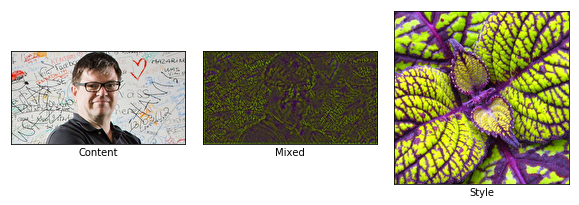

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 5.80e-11, Style: 2.77e-28, Denoise: 4.26e-08


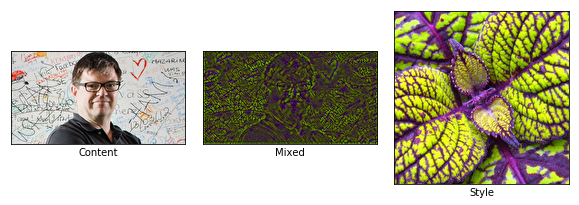

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 5.50e-11, Style: 1.68e-28, Denoise: 3.38e-08


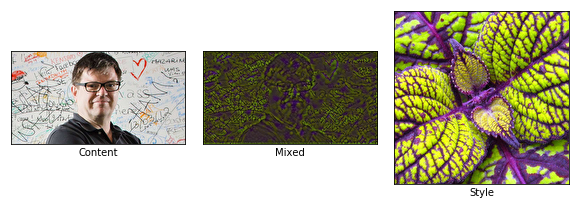


Final image:


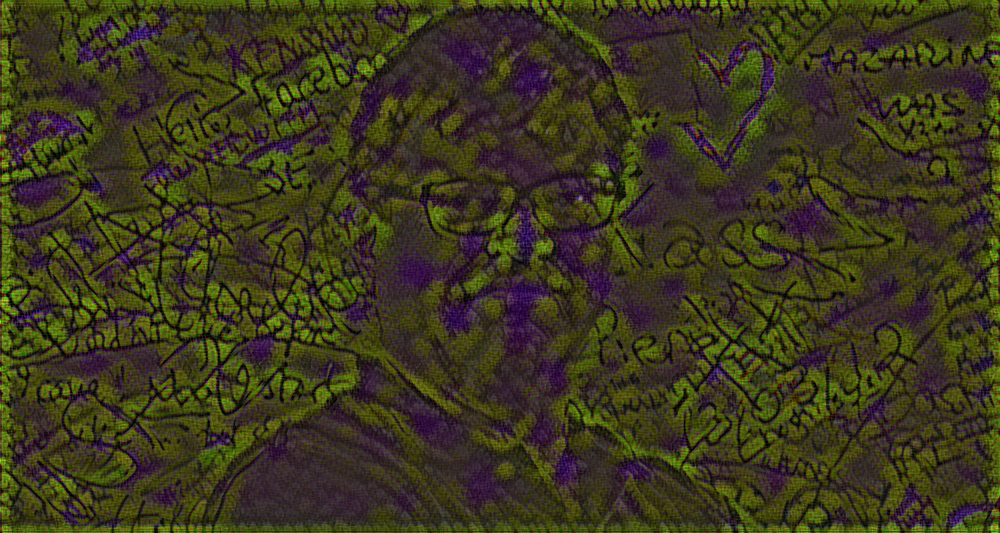

CPU times: user 15.7 s, sys: 4.53 s, total: 20.2 s
Wall time: 27.3 s


In [45]:
%%time


img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=15.0,
                     weight_denoise=0.1,
                     num_iterations=60,
                     step_size=10.0)

## Conclusion

From the iterations above, we can see that the mixed-image is the result of the textures extracted from the style-image and the prominent contours of the content-image. We have observed that style transfer performs best with the loss function - Mean Squared Error, compared to the rest. We have learnt the importance of Convolutional Neural Networks in the case of images and videos.  

##References:

[1] Magnus Erik Hvass Pedersen: http://www.hvass-labs.org/

[2] Artistic Style Transfer with Convolutional Neural Network: https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd

[3] Neural Algorithm of Artistic Style: 
https://arxiv.org/abs/1508.06576

[4]  Image Style Transfer: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

[5] Style Transfer: https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461